<span style="font-size: 23px;"> Linear Regression Model for predicting insurance price<span>

In [516]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.model_selection import train_test_split
import warnings 
from sklearn.linear_model import LinearRegression
warnings.filterwarnings("ignore")

<span style="font-size: 18px;">1. Load the data from CSV<span>

In [517]:
data = pd.read_csv('../insurance_data.csv',index_col=0)

<span style="font-size: 18px;">2. Perform the exploratory data analysis<span>

2.1. Showing first 10 rows of the data

In [518]:
data.head(10)

,sex,bmi,children,smoker,region,charges
age,,,,,,
19,female,27.900,0,yes,southwest,16884.92400
18,male,33.770,1,no,southeast,1725.55230
28,male,33.000,3,no,southeast,4449.46200
33,male,22.705,0,no,northwest,21984.47061
32,male,28.880,0,no,northwest,3866.85520
31,female,25.740,0,no,southeast,3756.62160
46,female,33.440,1,no,southeast,8240.58960
37,female,27.740,3,no,northwest,7281.50560
37,male,29.830,2,no,northeast,6406.41070


2.2. Check the shape i.e. dimension of data

In [519]:
data.shape

(1338, 6)

2.3. 5-point summary (like Median, 25%, 75%, Minimum and Maximum)

In [520]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


2.4. Information about the column (data types)

In [521]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1338 entries, 19 to 61
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sex       1338 non-null   object 
 1   bmi       1338 non-null   float64
 2   children  1338 non-null   int64  
 3   smoker    1338 non-null   object 
 4   region    1338 non-null   object 
 5   charges   1338 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 73.2+ KB


2.5. Check if any duplicate rows present or now

In [522]:
data.duplicated().sum()

1

2.6. Any missing value

In [523]:
print(data.isnull().sum())

sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


2.7. Categorical Treatment One hot encoding

In [524]:
data_encoded = pd.get_dummies(data, columns=['sex', 'smoker', 'region'], drop_first=True)
print(data_encoded.dtypes)
data= data_encoded

bmi                 float64
children              int64
charges             float64
sex_male               bool
smoker_yes             bool
region_northwest       bool
region_southeast       bool
region_southwest       bool
dtype: object


In [525]:
data.head(10)

,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
age,,,,,,,,
19,27.900,0,16884.92400,False,True,False,False,True
18,33.770,1,1725.55230,True,False,False,True,False
28,33.000,3,4449.46200,True,False,False,True,False
33,22.705,0,21984.47061,True,False,True,False,False
32,28.880,0,3866.85520,True,False,True,False,False
31,25.740,0,3756.62160,False,False,False,True,False
46,33.440,1,8240.58960,False,False,False,True,False
37,27.740,3,7281.50560,False,False,True,False,False
37,29.830,2,6406.41070,True,False,False,False,False


2.8. Correlation between variables

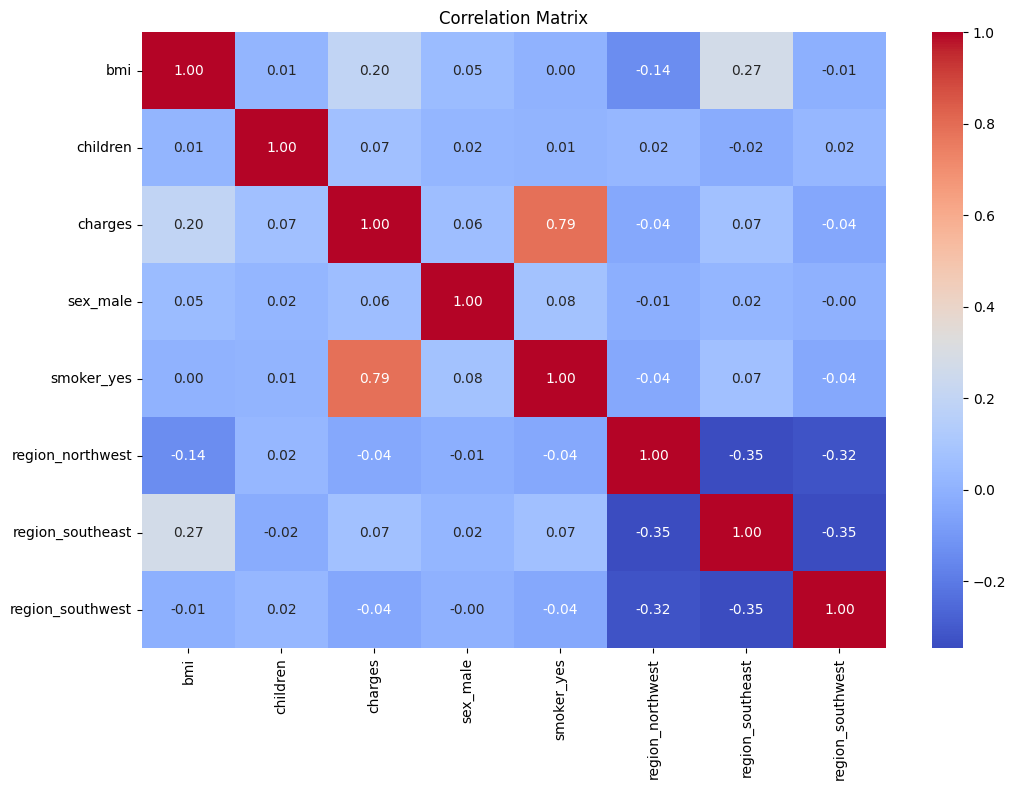

In [526]:
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

2.9. Number of outliers

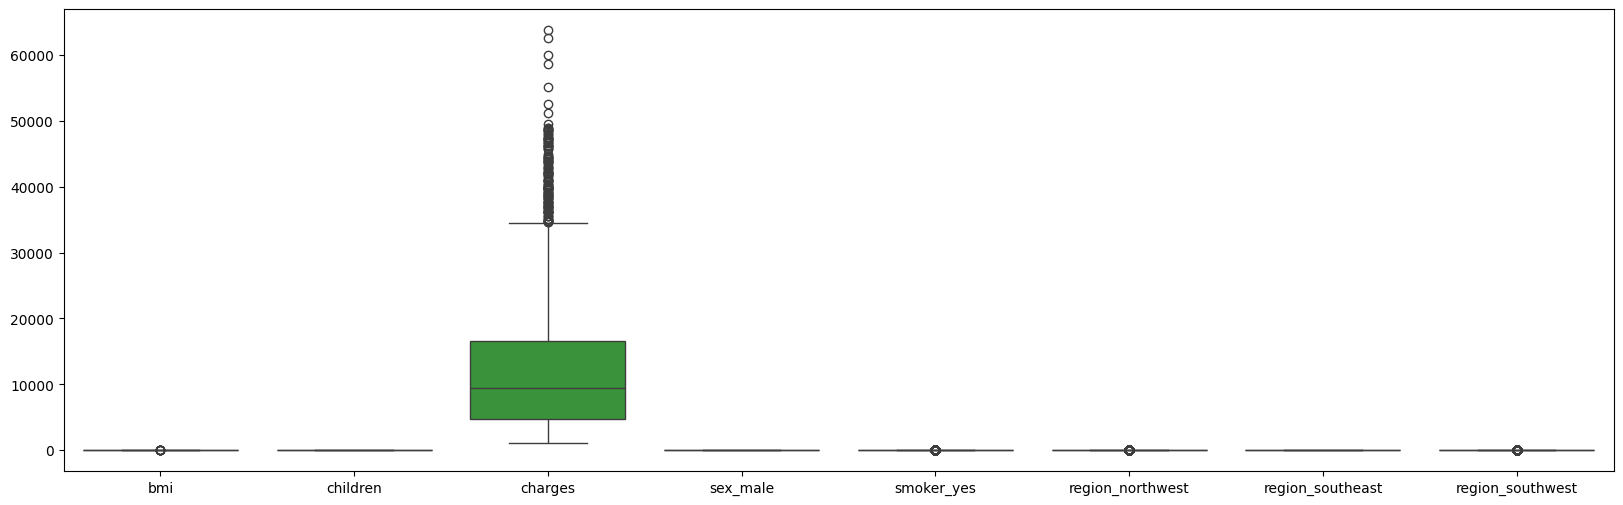

In [527]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=data)
plt.show()

2.10. A set of subplots to visualize the distribution

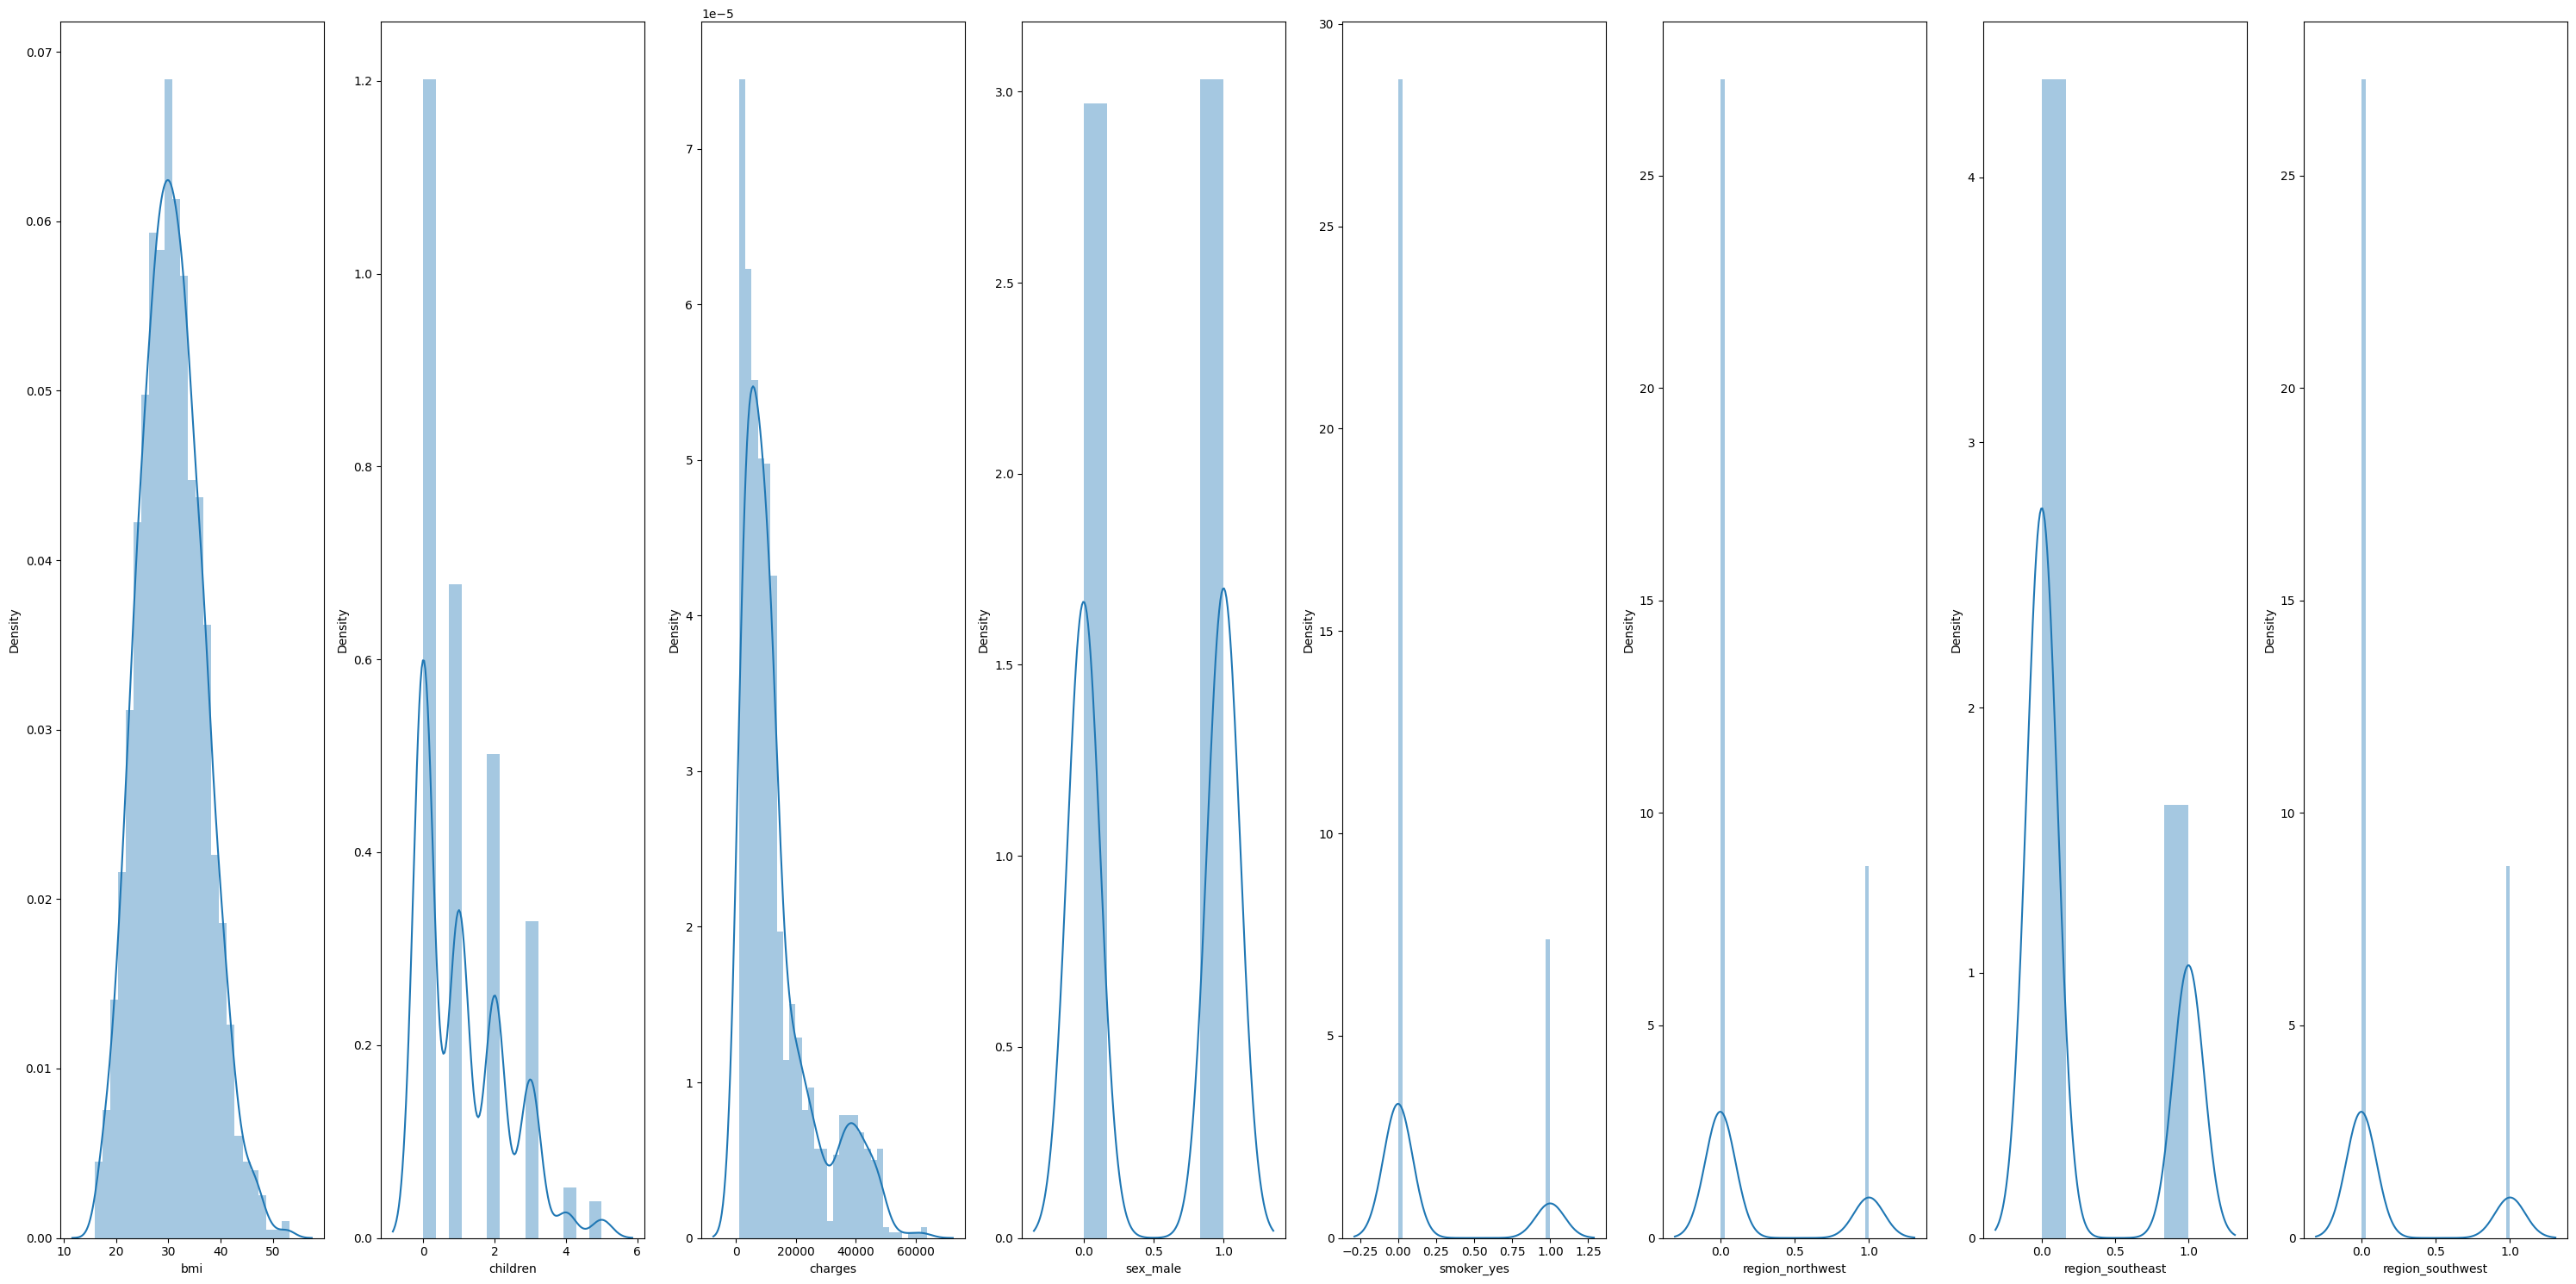

In [528]:
fig, axes = plt.subplots(ncols=len(data.columns), figsize=(30,15))
for ax, col in zip(axes, data.columns):
  sns.distplot(data[col], ax=ax)
  plt.tight_layout() 
plt.show()

2.11. Scatterplots showing relationships between pairs of variables

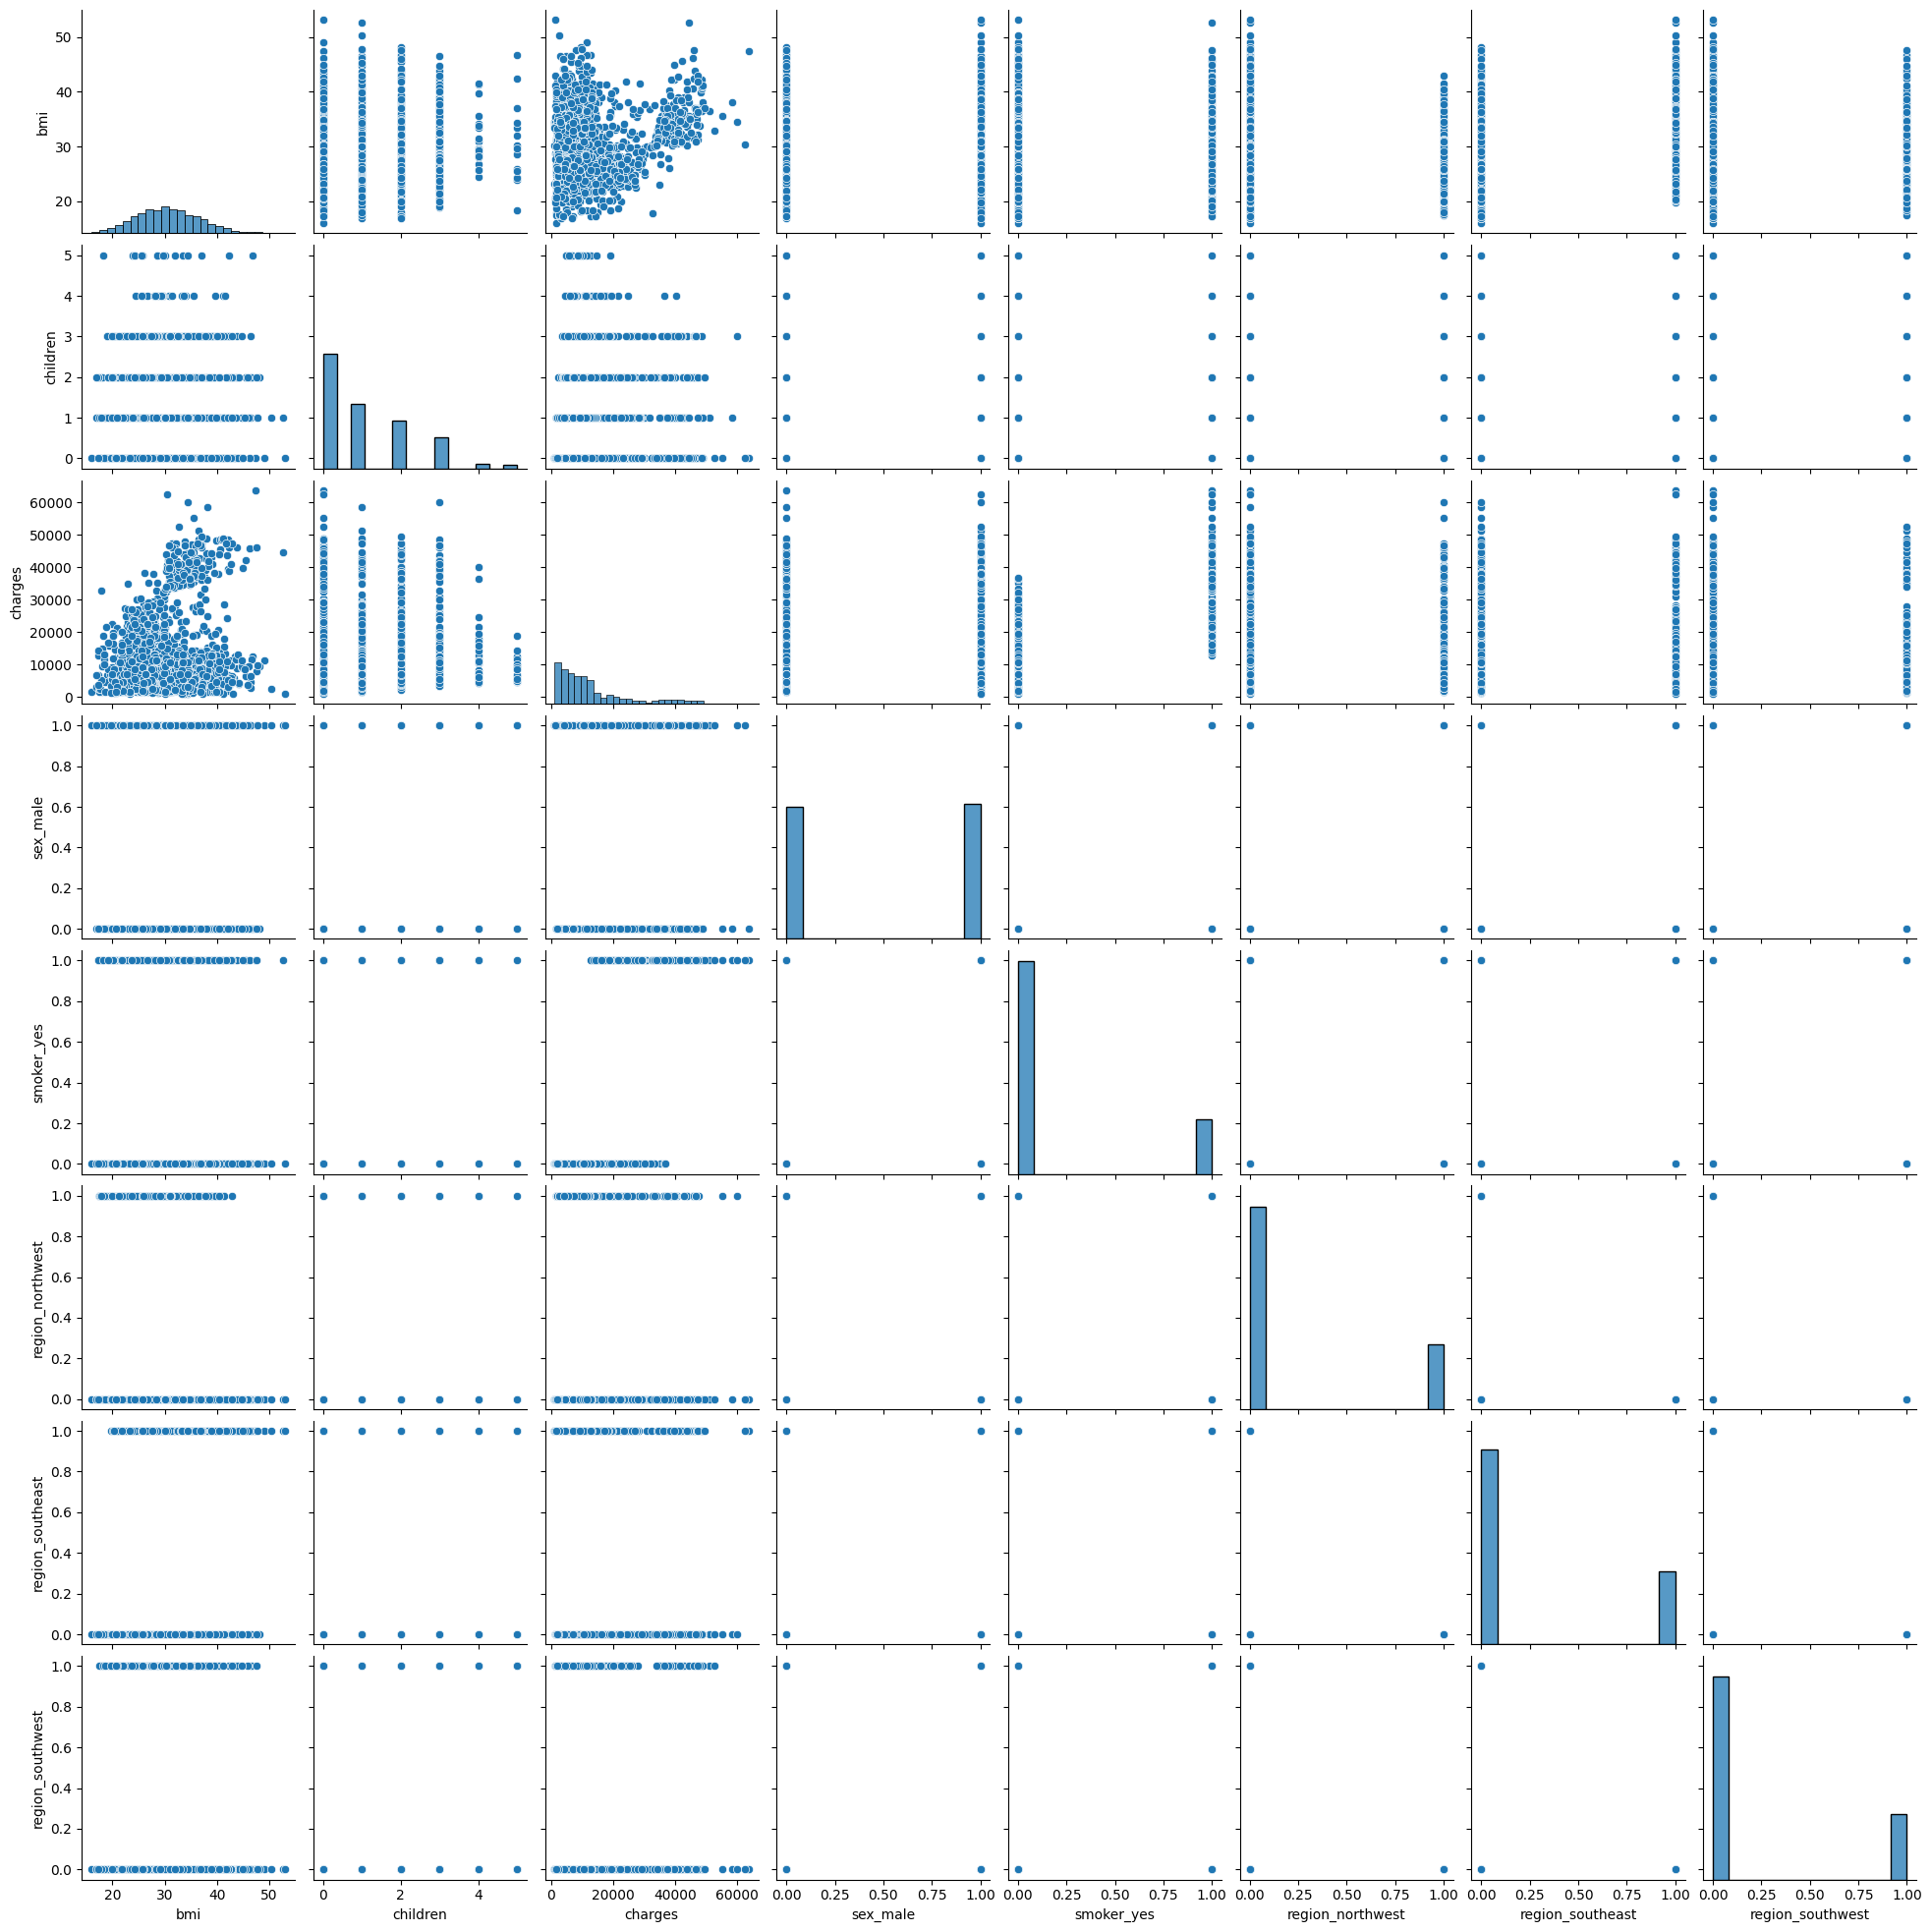

In [529]:
sns.pairplot(data)

2.12. Histogram Plot to see distribution of variables

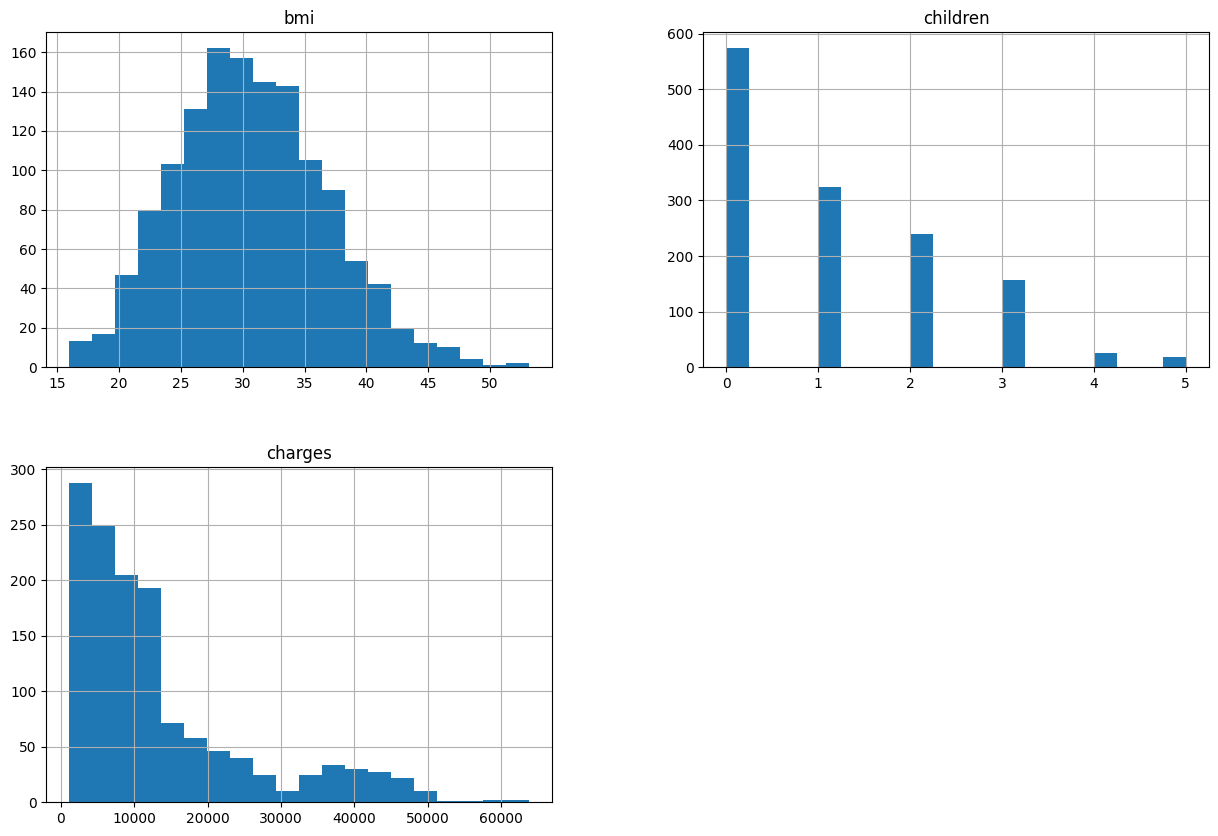

In [530]:
data.hist(figsize=(15, 10), bins=20)
plt.show()

2.13. Check if any missing value or Null value in each column

In [531]:
print(data.isnull().sum())

bmi                 0
children            0
charges             0
sex_male            0
smoker_yes          0
region_northwest    0
region_southeast    0
region_southwest    0
dtype: int64


<span style="font-size: 18px;">3. Data Preprocessing<span>

3.1. Removing Duplicate value

In [532]:
data.duplicated().sum()

1

In [533]:
data = data.drop_duplicates()
data.duplicated().sum()

0

3.2. Outlier treatment

3.2.1. Checking the outlier before treatment

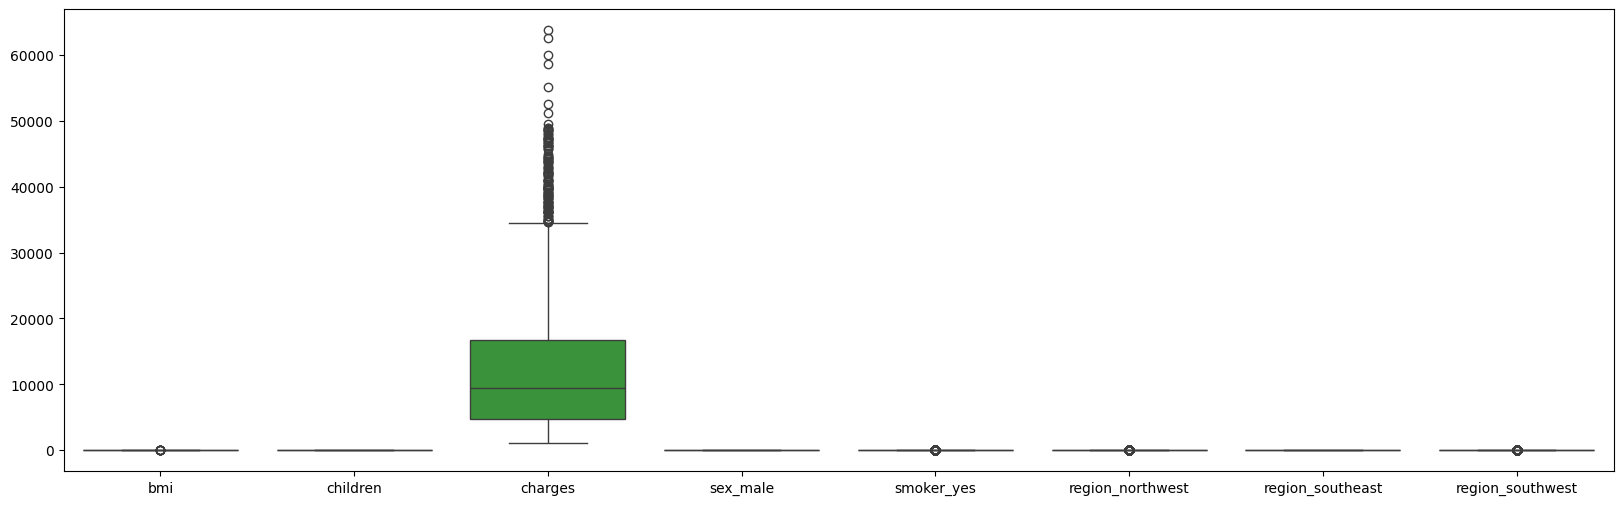

In [534]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=data)
plt.show()

3.2.2. Removing outlier

In [535]:
def outlier_cap(col):
    if np.issubdtype(col.dtype, np.number):  # Check if the column is numeric
        Q1, Q3 = np.percentile(col, [25, 75])
        IQR = Q3 - Q1
        lower_range = Q1 - (1.5 * IQR)
        upper_range = Q3 + (1.5 * IQR)
        return lower_range, upper_range
    else:
        return None


In [536]:
for column in data.columns[:-1].tolist():
    lr_ur = outlier_cap(data[column])
    if lr_ur is not None:
        lr, ur = lr_ur
        data[column] = np.where(data[column] > ur, ur, data[column])
        data[column] = np.where(data[column] < lr, lr, data[column])


3.2.3. Showing box plot after removing all outliers

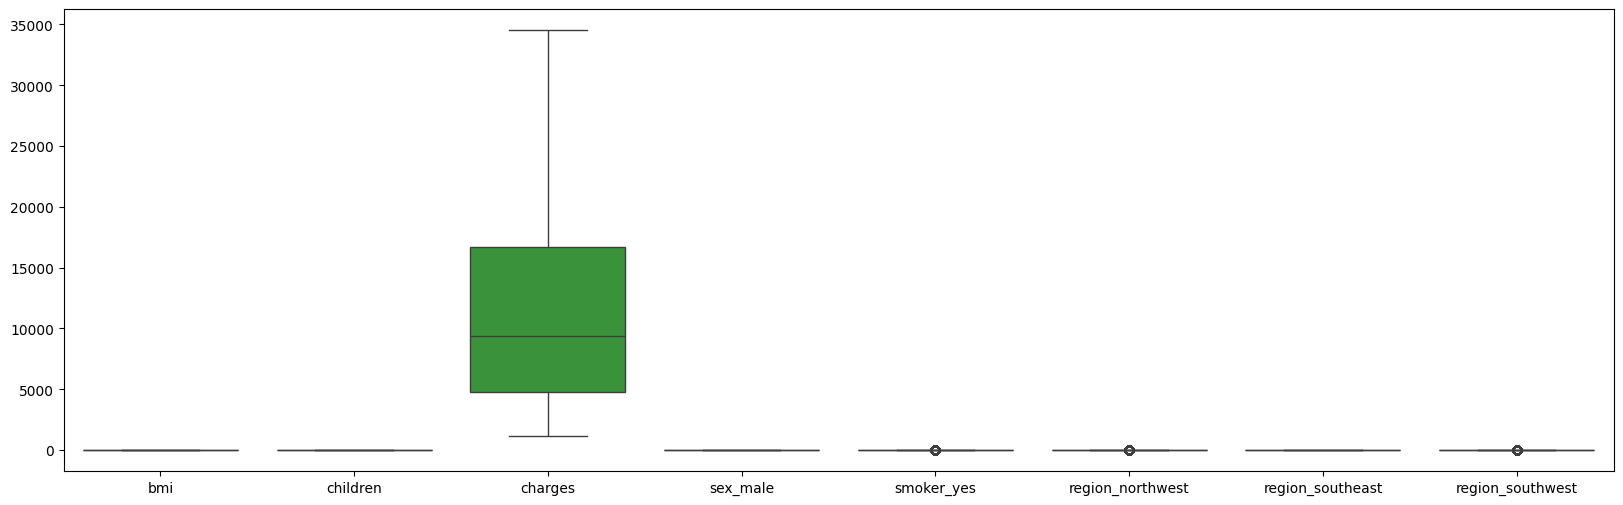

In [537]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=data)
plt.show()

<span style="font-size: 18px;">4. Split the dataset <span>

4.1. Spliting feature and response 

In [538]:
# Putting feature variable to X
X = data.drop('charges',axis=1)

# Putting response variable to y
y = data['charges']

4.2. Split the data into 80% training dataset and 20% test dataset

In [539]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, random_state=42)
X_train.shape, X_test.shape

((1069, 7), (268, 7))

<span style="font-size: 18px;">5. Model preparation and evaluation<span>

5.1. Train the model with test data

In [540]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

5.2. Co-efficient of liner equation

In [541]:
lr_model.coef_

array([  290.7021322 ,   609.73446806,  -418.60069532, 19421.92274164,
        -330.44393477, -1145.167521  ,  -606.32280698])

5.3. Score of the model

In [542]:
lr_model.score(X_train,y_train)

0.6295786821412375

5.4. Predict the trained and test data

5.4.1. Predict Train data

In [543]:
y_pred_train = lr_model.predict(X_train)

In [544]:
RMSE = sqrt(sum((y_pred_train - y_train)**2)/len(y))
RMSE

5435.3982055616025

5.4.2. Predict Test data

In [545]:
y_pred_test = lr_model.predict(X_test)

In [546]:
RMSE = sqrt(sum((y_pred_test - y_test)**2)/len(y))
RMSE

2581.572415325624

In [551]:
X_train.shape

(1069, 7)

In [552]:
y_train.shape

(1069,)

5.5. Linear Regression Plot

5.5.1. Plot for training data set (Considered only smoking flag as it has high impact)

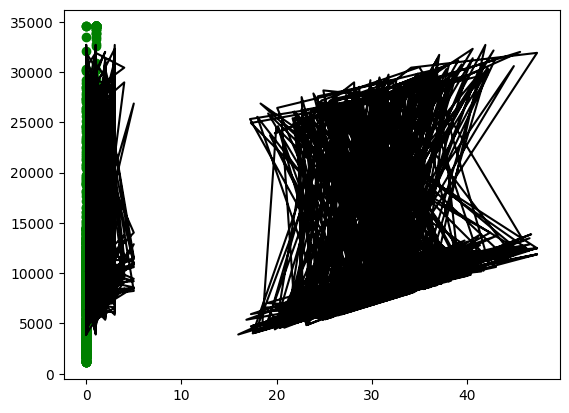

In [572]:
plt.scatter(X_train["smoker_yes"], y_train,color='g')
plt.plot(X_train, y_pred_train,color='k')
plt.show()

5.5.2. Plot for test data set (Considered only smoking flag as it has high impact)

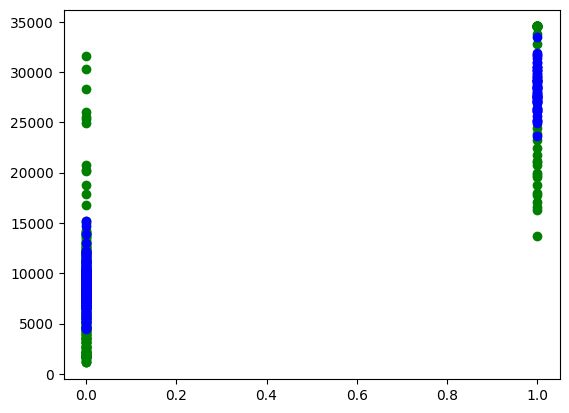

In [575]:
plt.scatter(X_test["smoker_yes"], y_test,color='g')
plt.scatter(X_test["smoker_yes"], y_pred_test,color='b')
plt.show()

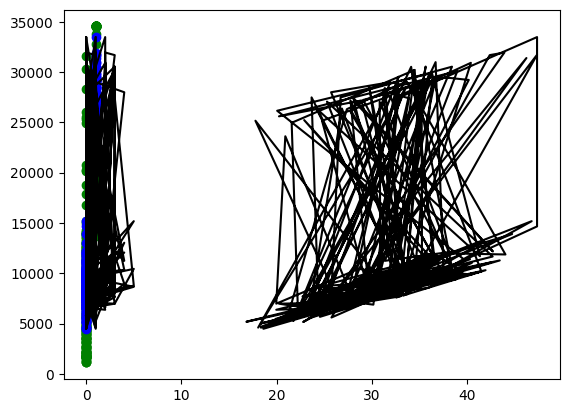

In [578]:
plt.scatter(X_test["smoker_yes"], y_test,color='g')
plt.scatter(X_test["smoker_yes"], y_pred_test,color='b')
plt.plot(X_test, y_pred_test,color='k')
plt.show()